In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(54, 24)

In [6]:
df_states.shape

(2620, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-04-17,56,694520,2862973.0,10889.0,57821.0,77955.0,14910.0,2052.0,6096.0,...,32365,77955.0,3568382,3557493,3557493,2069.0,3250.0,125169.0,31260.0,156429.0
3,2020-04-18,56,722182,2976352.0,9906.0,56554.0,78839.0,14788.0,2096.0,5729.0,...,34139,78839.0,3708440,3698534,3698534,1774.0,884.0,113379.0,27662.0,141041.0
2,2020-04-19,56,749203,3116661.0,11324.0,55490.0,80881.0,14548.0,2145.0,5603.0,...,35793,80881.0,3877188,3865864,3865864,1654.0,2042.0,140309.0,27021.0,167330.0
1,2020-04-20,56,772524,3231027.0,4037.0,55509.0,82879.0,14691.0,2193.0,5567.0,...,37321,82879.0,4007588,4003551,4003551,1528.0,1998.0,114366.0,23321.0,137687.0
0,2020-04-21,56,799717,3355461.0,3956.0,58468.0,84292.0,15228.0,2315.0,5514.0,...,39995,84292.0,4159134,4155178,4155178,2674.0,1413.0,124434.0,27193.0,151627.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-21,NE,1648.0,14724.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16372.0,16372.0,16372.0,31,5.0,0.0,518.0,174.0,692.0
31,2020-04-21,ND,644.0,14343.0,NaN,17.0,54.0,NaN,NaN,NaN,...,54.0,14987.0,14987.0,14987.0,38,0.0,1.0,223.0,17.0,240.0
30,2020-04-21,NC,6951.0,76380.0,NaN,427.0,NaN,NaN,NaN,NaN,...,NaN,83331.0,83331.0,83331.0,37,34.0,0.0,3660.0,187.0,3847.0
28,2020-04-21,MS,4716.0,47648.0,NaN,548.0,858.0,146.0,NaN,89.0,...,858.0,52364.0,52364.0,52364.0,28,14.0,39.0,726.0,204.0,930.0
0,2020-04-21,AK,329.0,10790.0,NaN,42.0,36.0,NaN,NaN,NaN,...,36.0,11119.0,11119.0,11119.0,2,0.0,0.0,987.0,8.0,995.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per 100,000
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e5)

# Calculate hospitalized per 100,000
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e5)

# Calculate deaths per 100,000
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e5)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per 100,000 people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e5)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
2467,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2468,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
2469,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2470,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2471,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,2472.000000,2357.000000,531.000000,674.000000,863.000000,319.000000,148.000000,266.000000,45.000000,567.000000,...,2420.000000,2472.000000,2.472000e+03,2435.000000,2472.000000,863.000000,1800.000000,2352.000000,2357.000000,1494.000000
mean,4827.108010,21500.299109,1743.856874,1535.879822,1531.173812,781.517241,195.540541,349.823308,73.377778,1171.174603,...,1715.782645,29.701861,6.458652e+06,427.668694,58.904374,13.777752,2.848203,0.131847,453.398109,232.047237
std,18460.703172,40168.003407,8295.285974,3247.706034,6434.068693,1198.869580,198.415299,455.477012,47.354221,3702.498711,...,3591.820967,16.427431,7.291438e+06,1590.996882,128.440523,32.816736,7.088557,0.138086,549.791086,958.853309
min,0.000000,0.000000,0.000000,10.000000,0.000000,9.000000,6.000000,4.000000,2.000000,2.000000,...,-638.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,459.000000,6.000000,83.000000,50.000000,83.500000,42.250000,27.000000,39.000000,69.000000,...,47.750000,17.000000,1.805832e+06,54.955978,1.105300,3.060769,0.142358,0.051954,16.520665,7.285714
50%,476.000000,6880.000000,40.000000,302.000000,212.000000,186.000000,145.000000,89.000000,57.000000,235.000000,...,496.500000,30.000000,4.468402e+06,107.860112,17.319699,6.517749,0.749148,0.093639,258.079777,28.785714
75%,2567.750000,24659.000000,268.000000,1437.500000,657.500000,1166.000000,260.000000,507.000000,108.000000,610.000000,...,1796.000000,42.500000,7.535591e+06,229.511156,59.429757,12.353254,2.361335,0.158262,710.113710,118.857143
max,251690.000000,397635.000000,64400.000000,18825.000000,57103.000000,5225.000000,838.000000,1705.000000,157.000000,23887.000000,...,78400.000000,72.000000,3.955704e+07,11490.119540,1287.930141,292.203404,75.876785,0.924528,3720.083419,13286.571429


## California

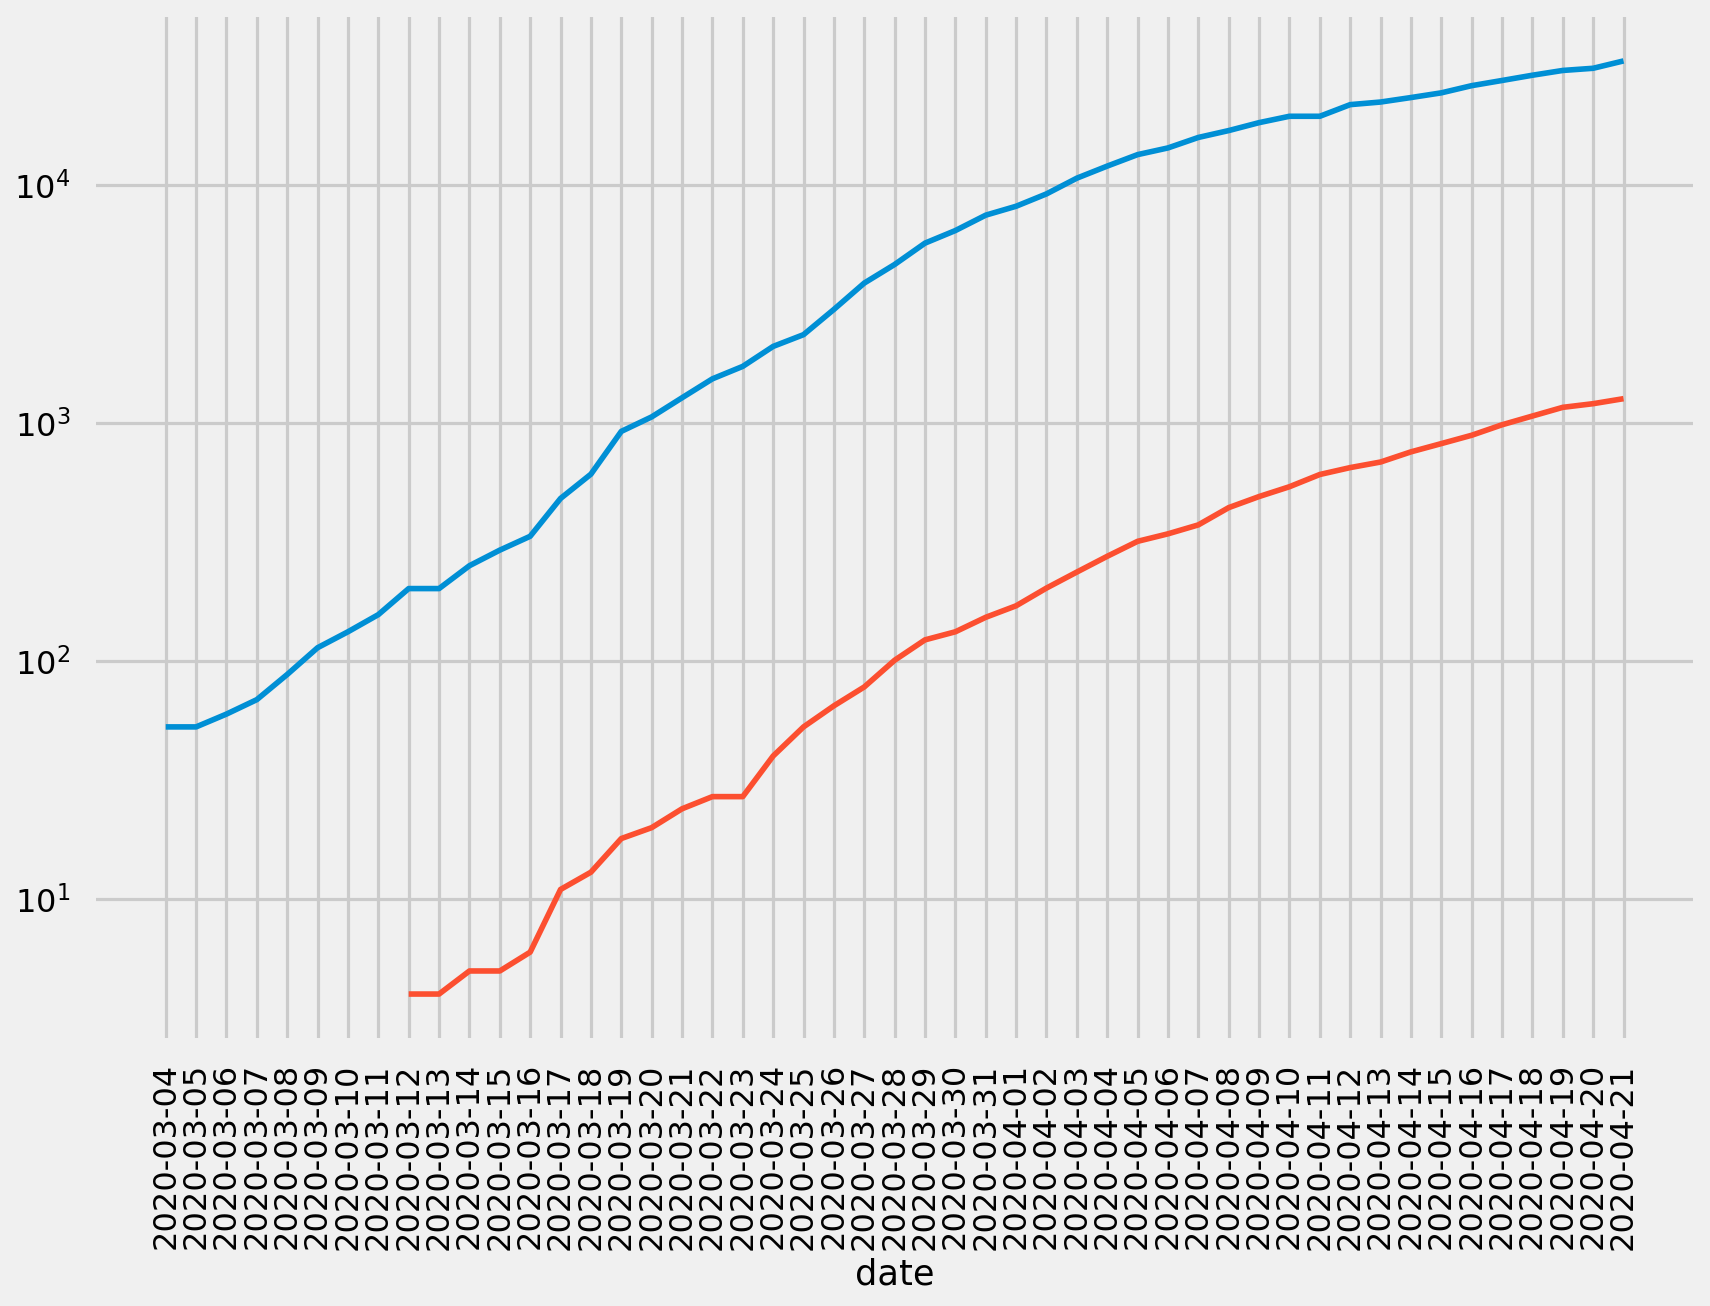

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

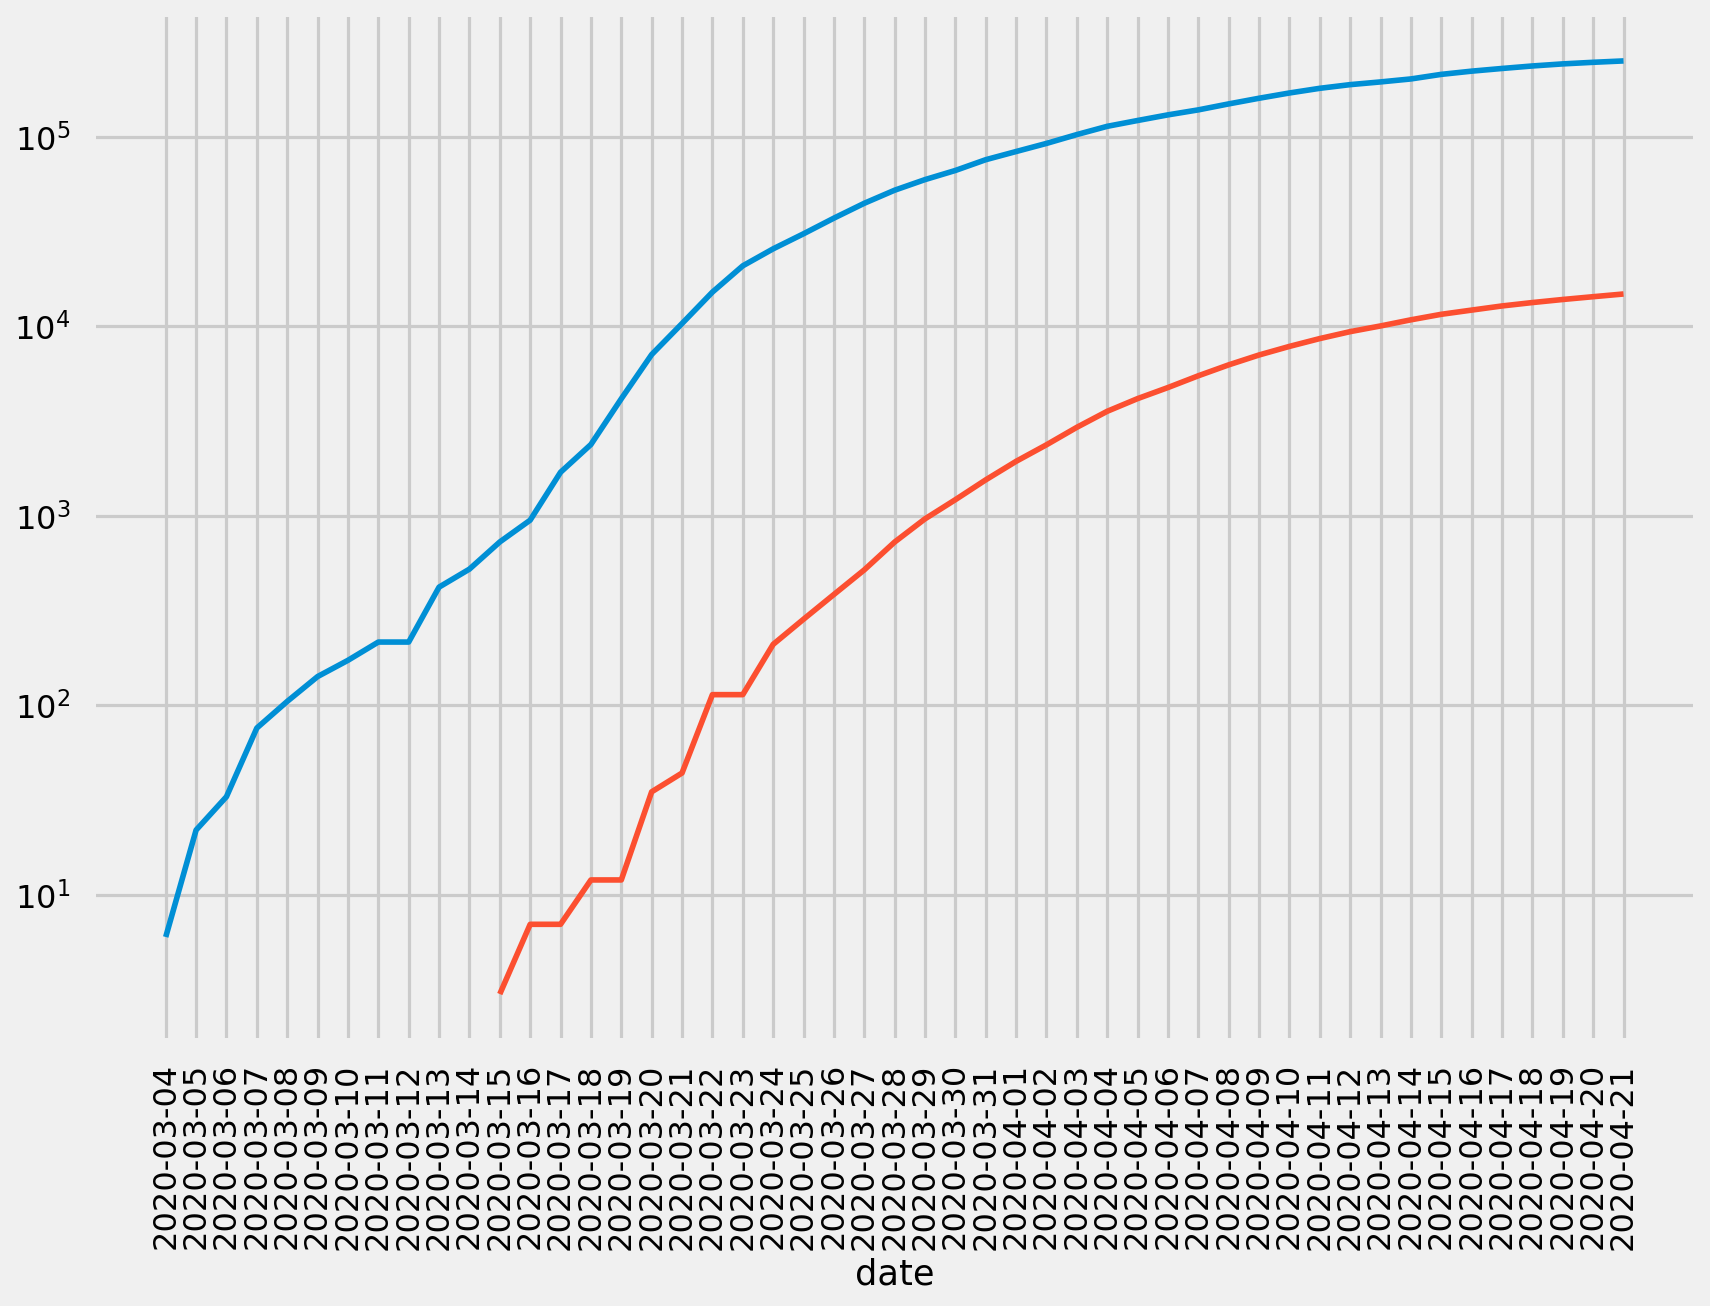

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'MA', 'PA', 'IL', 'CT', 'LA', 'CA', 'FL']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1615,NY,14828.0
1472,NJ,4753.0
1043,MI,2700.0
900,MA,1961.0
1807,PA,1564.0
664,IL,1468.0
286,CT,1423.0
854,LA,1405.0
189,CA,1268.0
427,FL,856.0


In [18]:
# Deaths per 100,000 people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1615,NY,75.876785
1472,NJ,53.353419
286,CT,39.830211
854,LA,30.150357
900,MA,28.411441
1043,MI,27.011034
1891,RI,16.173042
332,DC,15.944082
1807,PA,12.212014
664,IL,11.521786


# Deaths

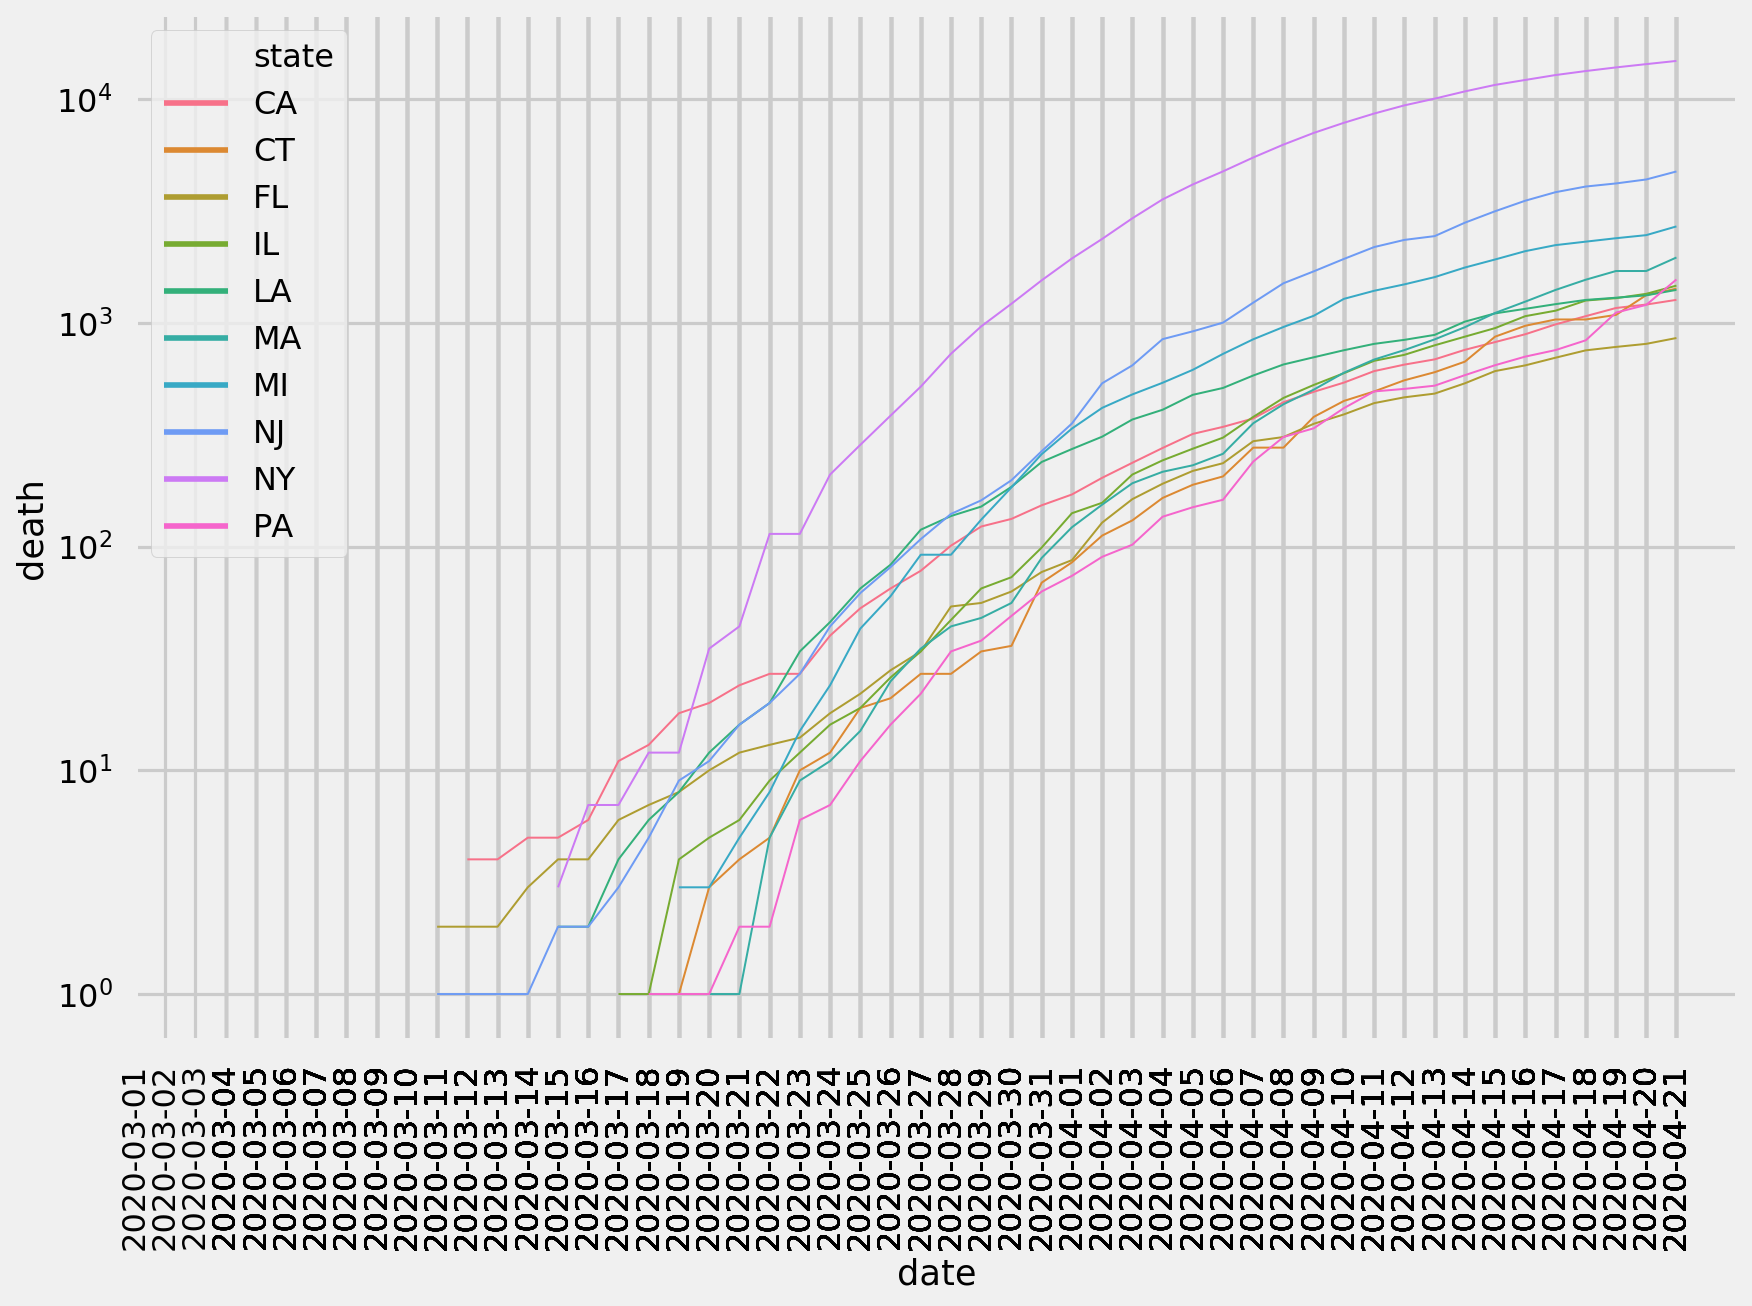

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

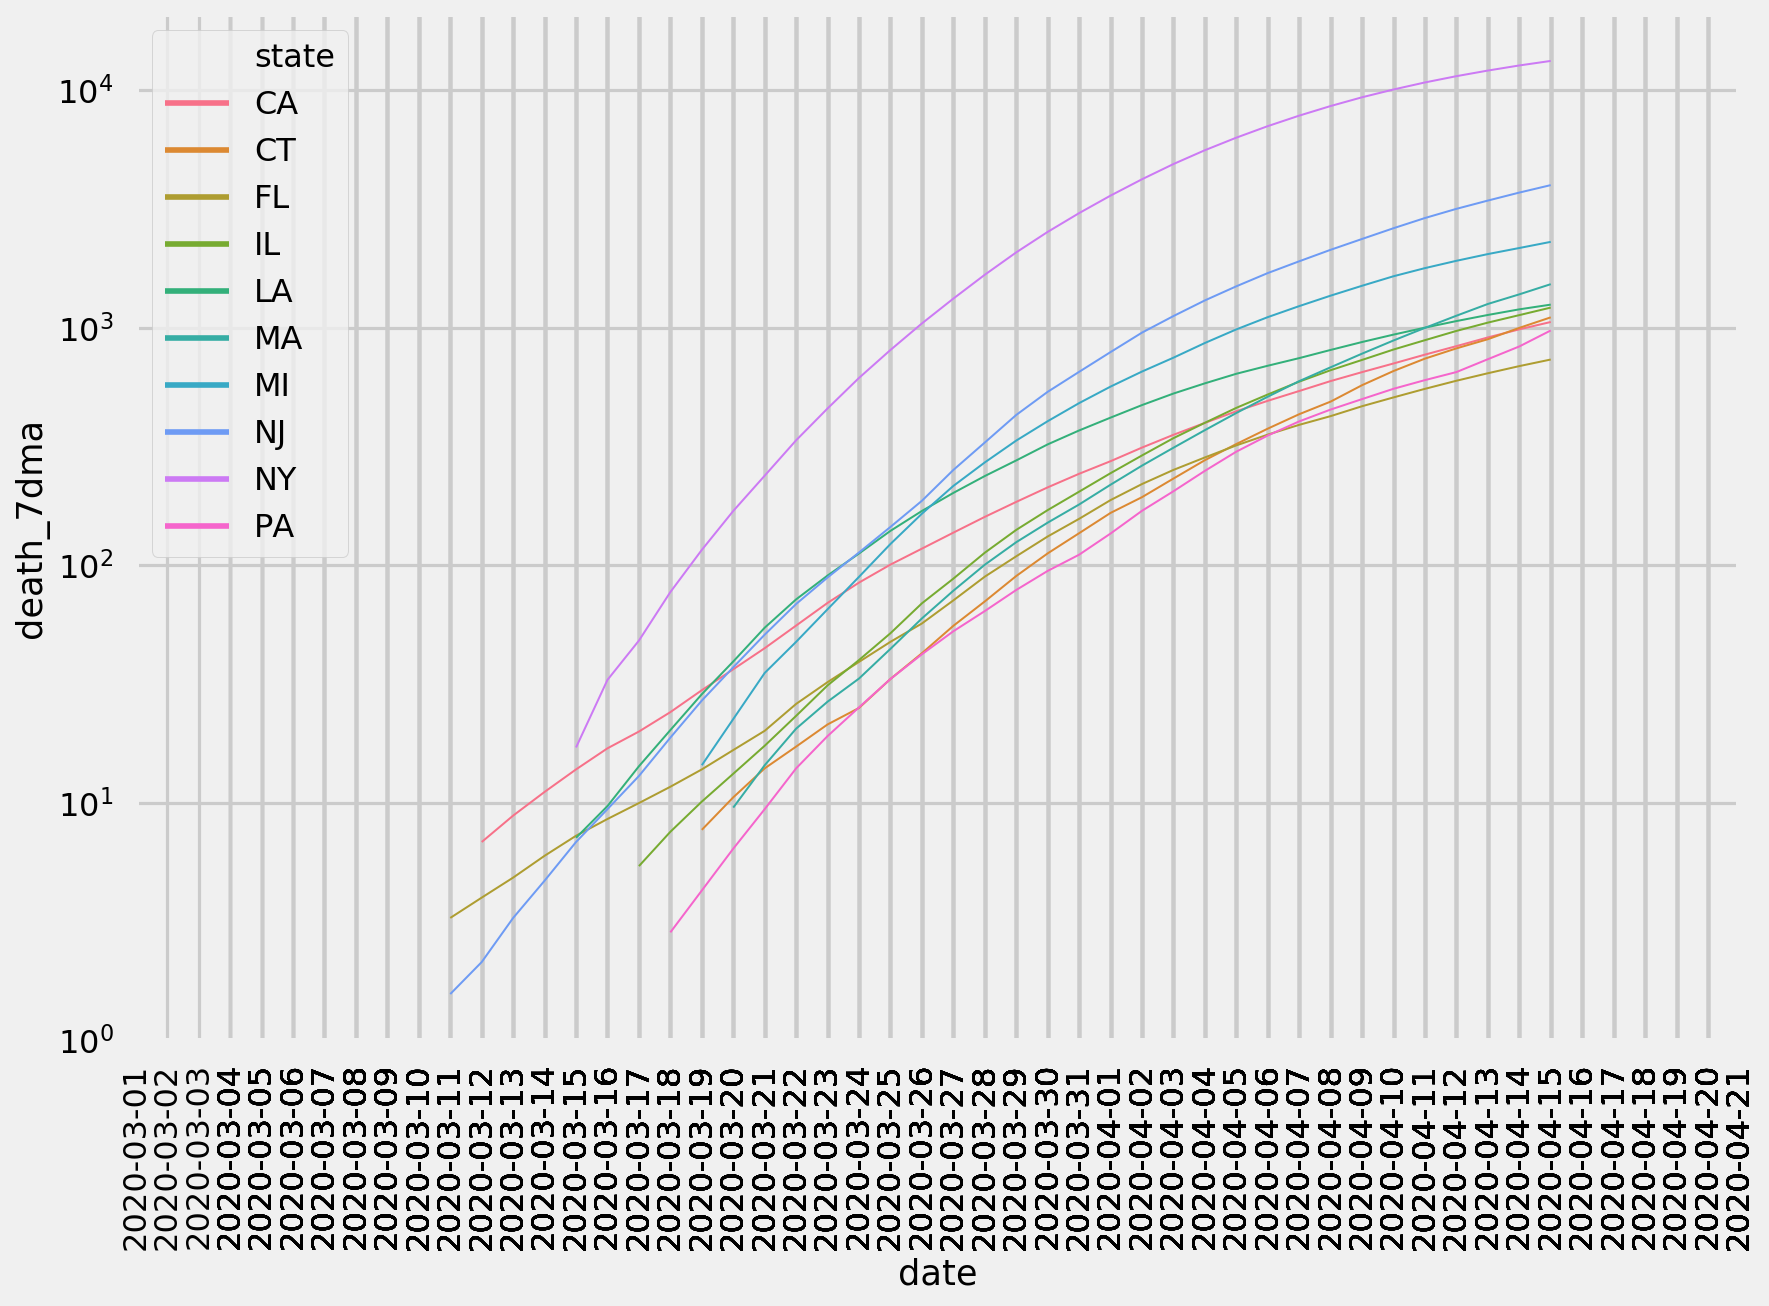

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per 100,000 People

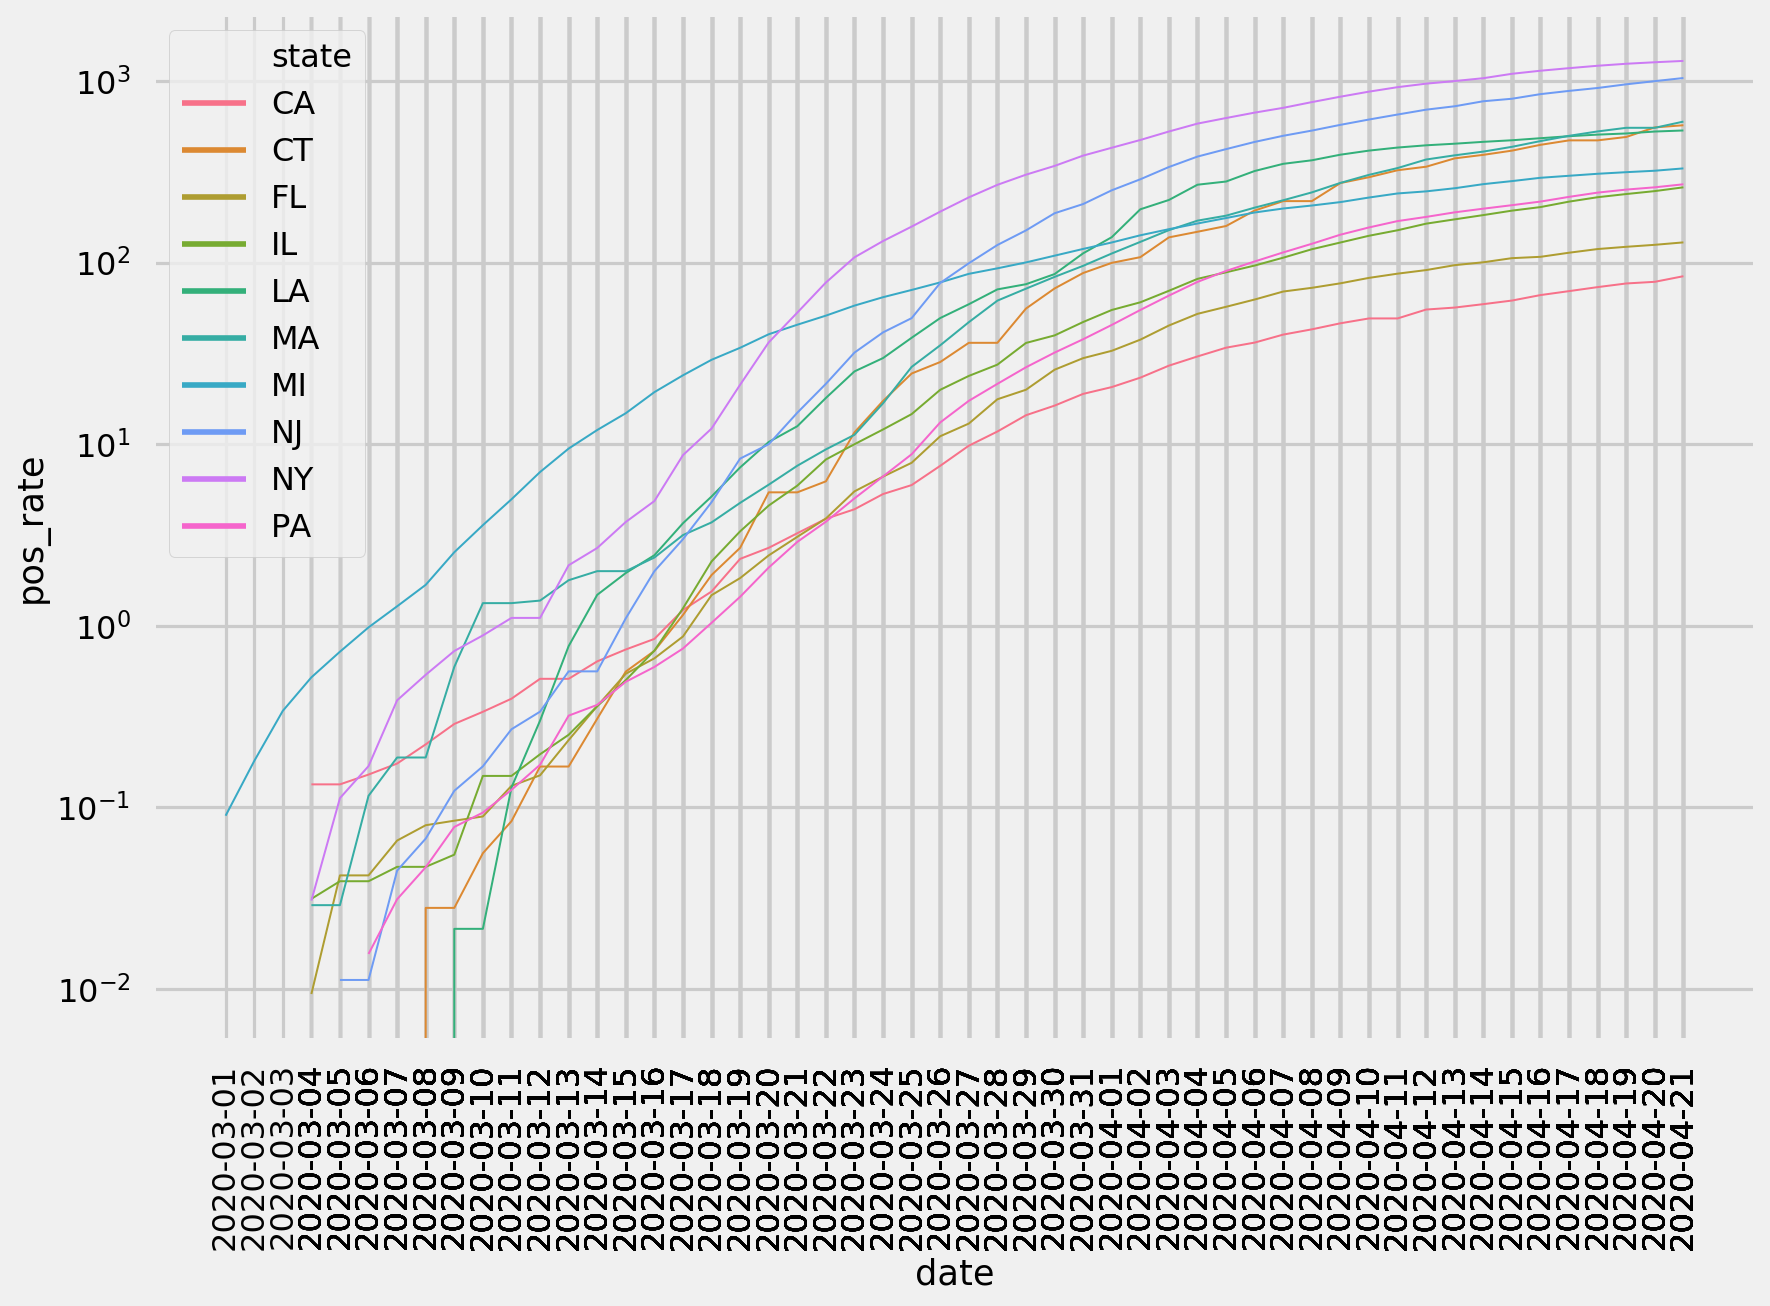

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per 100,000 People

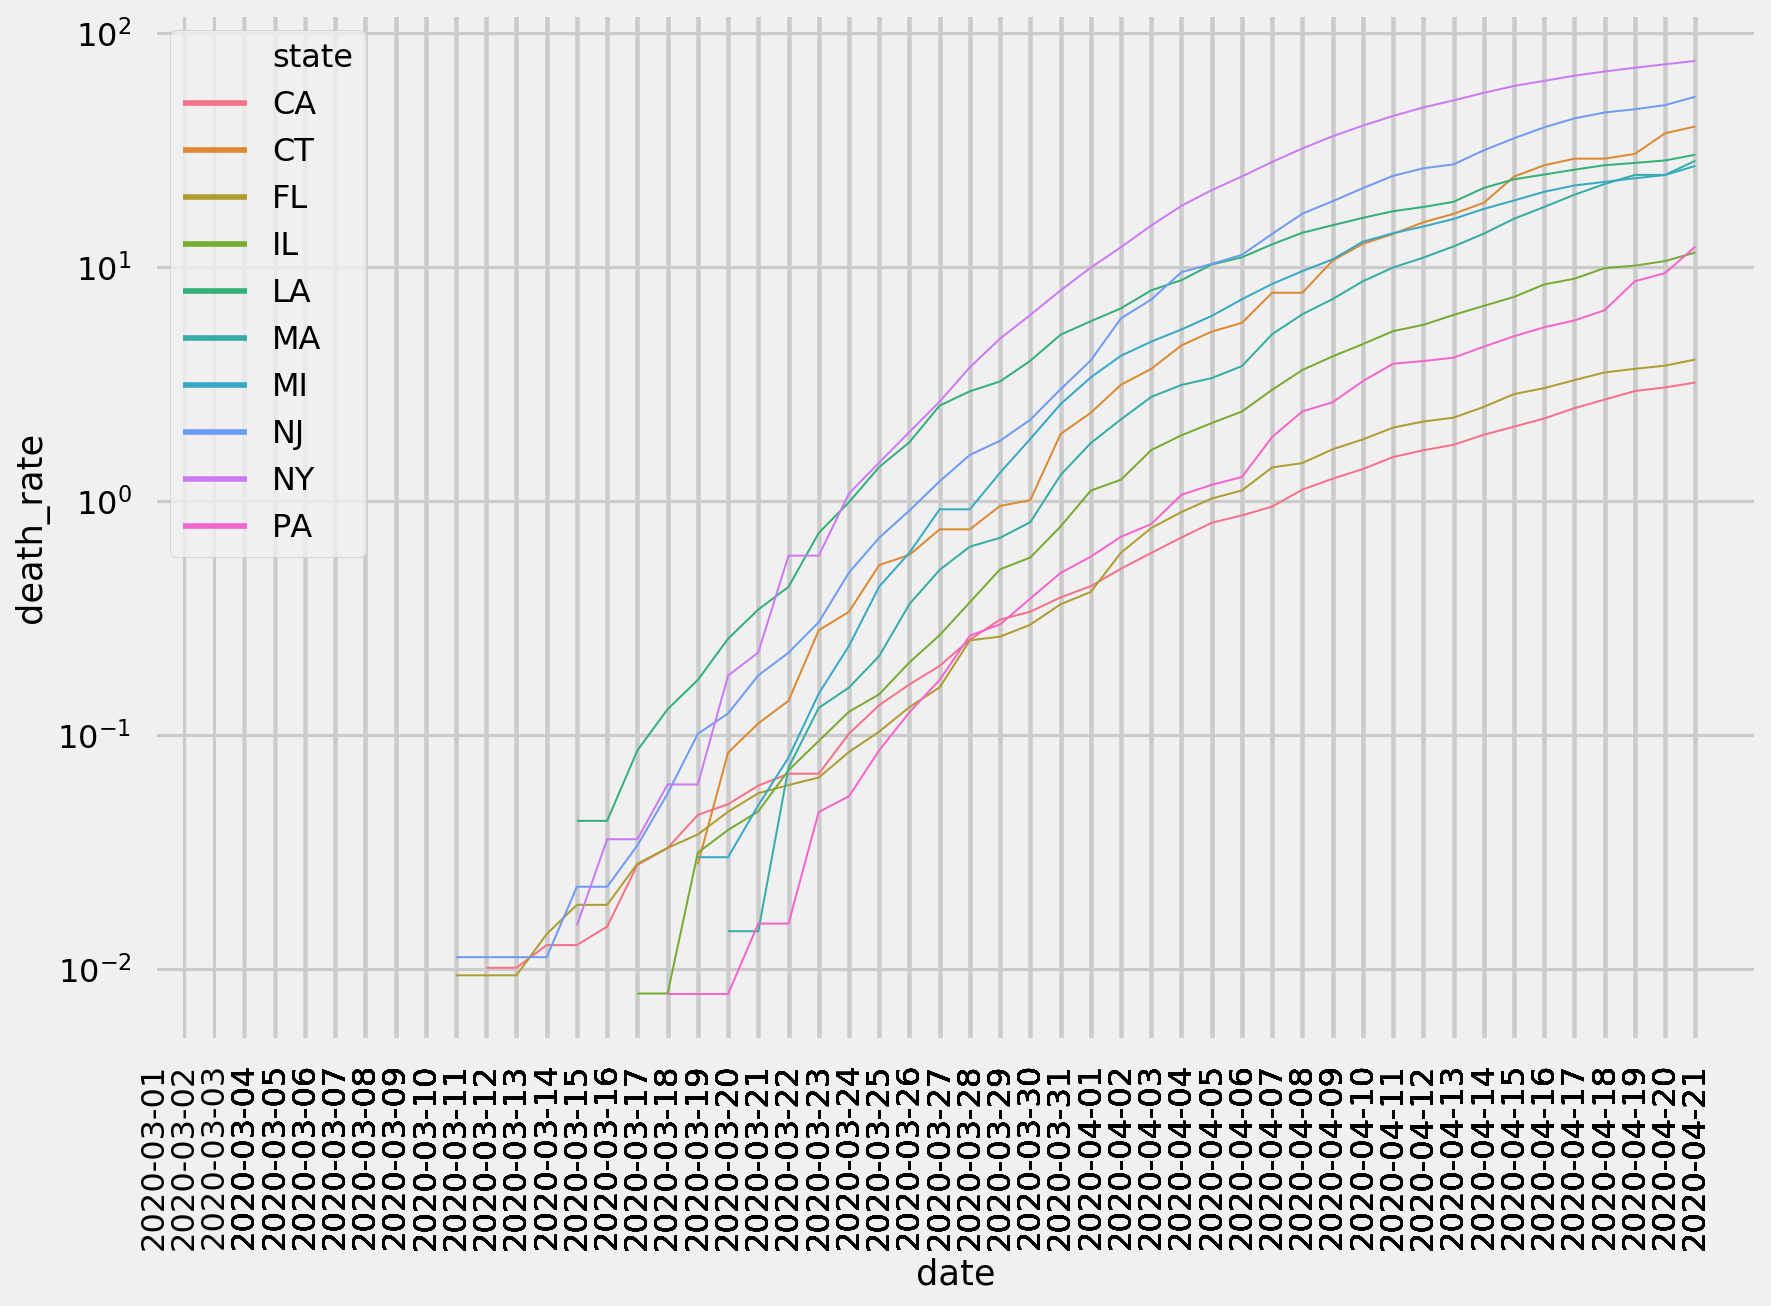

In [22]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per 100,000 People

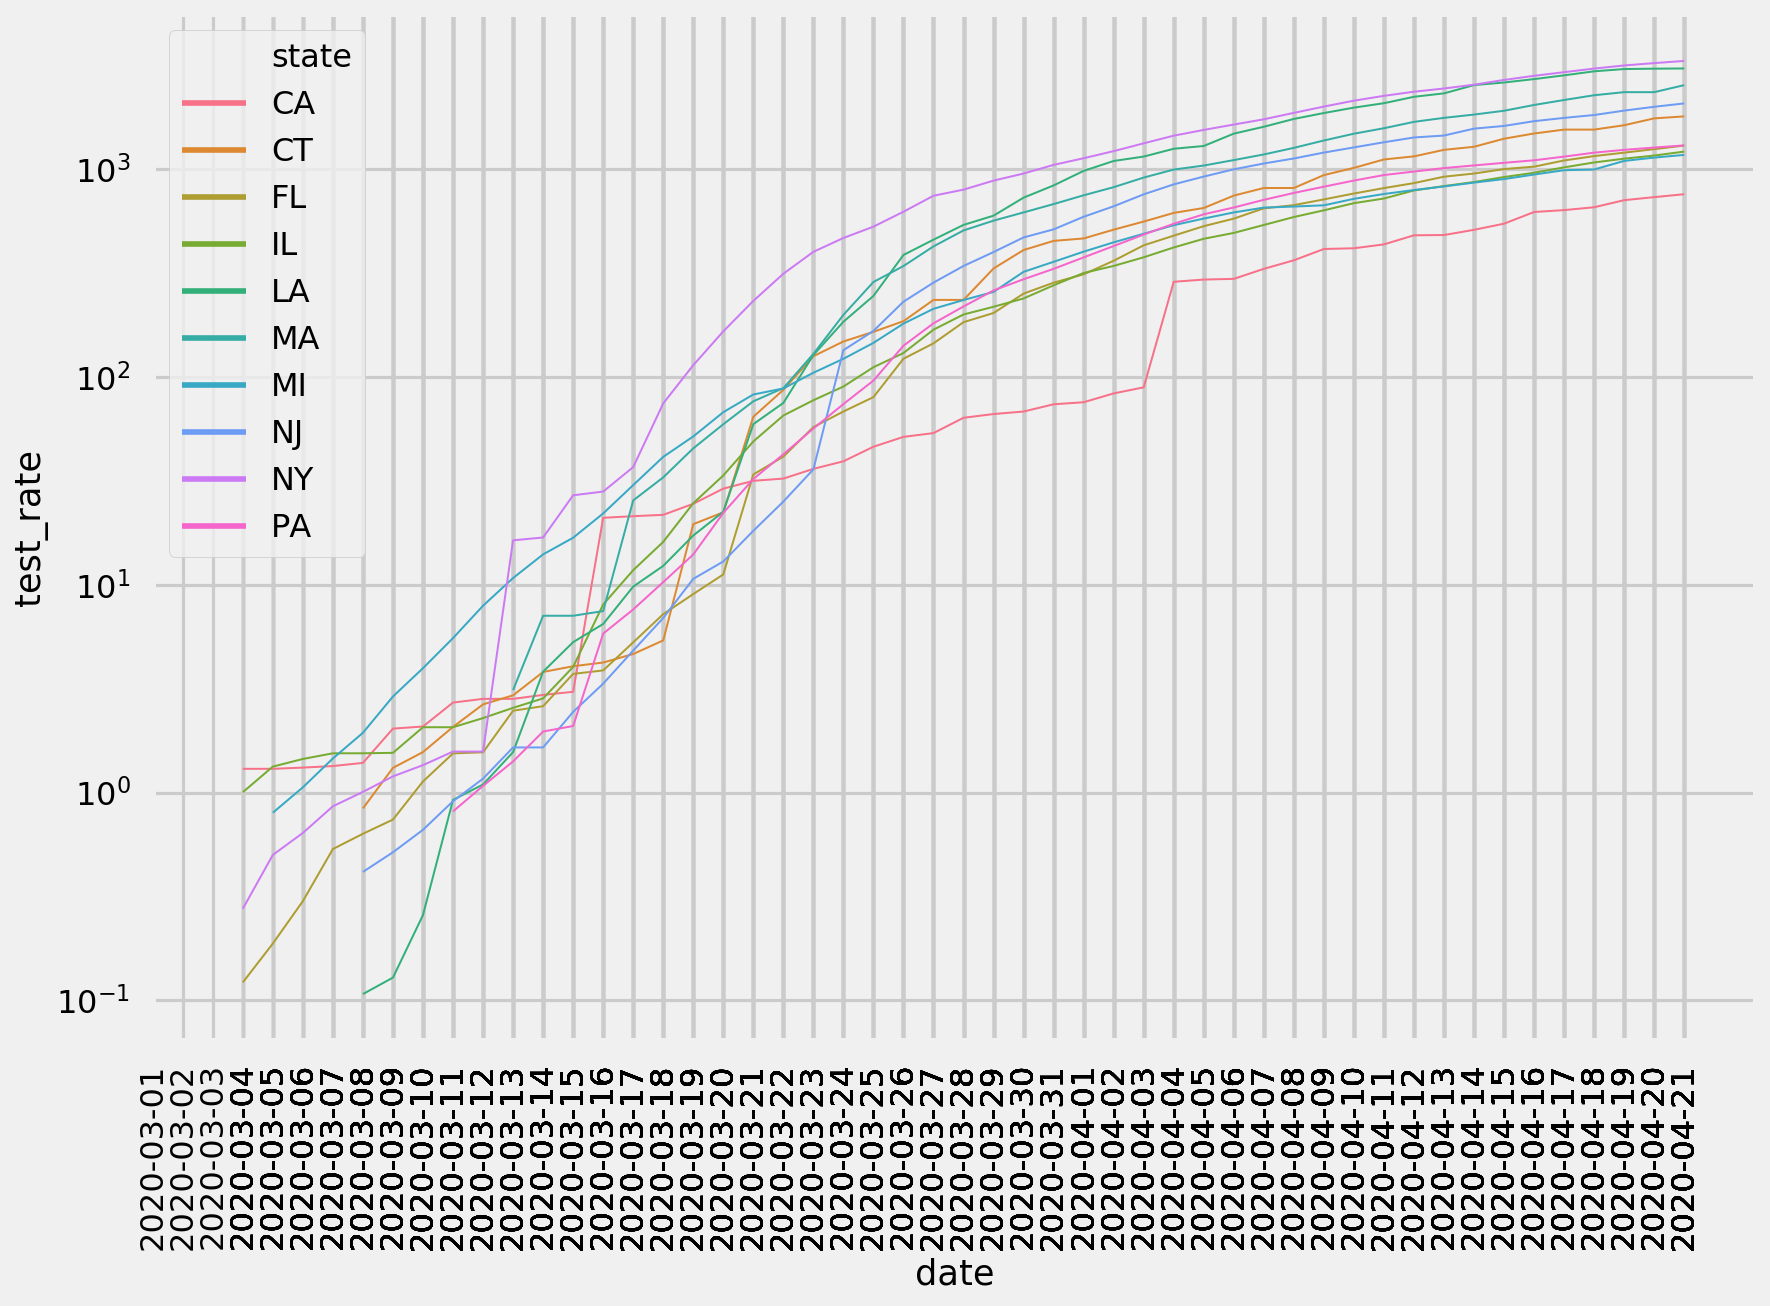

In [23]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [24]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
1891,RI,3720.083419
1615,NY,3322.679642
854,LA,3056.452198
900,MA,2540.831848
2135,UT,2289.009698
332,DC,2126.684272
2229,VT,2093.409059
1472,NJ,2074.710502
1329,ND,1971.773912
2276,WA,1871.266633
